In [1]:
import pymc3 as pm3
import plots_jordi as pts
import numpy as np
from MW_M31_rotation_curve_padila import v2_DM, M_t,M_CNFW
from MW_M31_rotation_curve import RC_miyamoto
import matplotlib.pyplot as plt
from rotation_curves_SPARC_padilla2 import g
import arviz as az

In [2]:
np.random.seed(12345)
sat = '/home/jordi/satellite'
dirfitsG = '/home/jordi/satellite/MW_rotation_curve_data/Fits/Gaussian/'
dirdata = '/home/jordi/satellite/MW_rotation_curve_data'
dataM31 = np.loadtxt('%s/M31_rotation_curve_data.txt'%sat)
dataGrandMW= np.loadtxt("%s/Table_GrandRC.dat.txt"%dirdata) 
c = 2.99792458e5 ## km/s
Gentc2 = 4.799e-7 ##G/c^2 en kpc/(10^10 M_sol)
G = Gentc2*c*c

In [6]:
rad, v, v_error = dataGrandMW.T
#rad, v, v_error =rad[:118], v[:118], v_error[:118]
def f(r, Mc, Rc):
    return Mc*(-2.*np.exp(-r**2/Rc**2)*r + np.sqrt(np.pi)*Rc*pm3.math.erf(r/Rc))/(Rc*np.sqrt(np.pi))  

def v2_DMatter(r, Rc, Mc, re, rs):## M es entre 10^10 M_sol
    rhos = Mc*re*np.exp(-re**2/Rc**2)*(1. + re/rs)**2/(rs*np.sqrt(np.pi)**3*Rc**3)
    Mh = pm3.math.switch(r>re, f(re, Mc, Rc) + 4.*np.pi*rs**3*rhos*(g(r, rs) - g(re, rs)),
                    f(r, Mc, Rc))
    ve2 = G*Mh/r
    return ve2

In [7]:
MO = {'Rc' : [0.001, 70., 36.], 'Mc' : [0.001, 500., 12.6],
      're' : [0.001, 150., 30.], 'rs' : [0.001, 300., 150.], 
      'Md' : [0.001, 20., 10.0], 
      'ad' : [0.001, 10., 3.],'bd' : [0.001, 8.0, 1.8],
      'Mb' : [0.001, 3.5, 1.25], 'bb' : [0.001, 1., 0.31]}
    
nsamples = 10000

In [8]:
with pm3.Model() as model: 
    Rc = pm3.Uniform(r'$R_c$', MO['Rc'][0], MO['Rc'][1], testval = MO['Rc'][2])
    Mc = pm3.Uniform(r'$M_c$', MO['Mc'][0], MO['Mc'][1], testval = MO['Mc'][2])
    re = pm3.Uniform(r'$r_e$', MO['re'][0], MO['re'][1], testval = MO['re'][2])
    rs = pm3.Uniform(r'$r_s$', MO['rs'][0], MO['rs'][1], testval = MO['rs'][2])  
    Md = pm3.Uniform(r'$M_d$', MO['Md'][0], MO['Md'][1], testval = MO['Md'][2])
    ad = pm3.Uniform(r'$a_d$', MO['ad'][0], MO['ad'][1], testval = MO['ad'][2])
    bd = pm3.Uniform(r'$b_d$', MO['bd'][0], MO['bd'][1], testval = MO['bd'][2])
    Mb = pm3.Uniform(r'$M_b$', MO['Mb'][0], MO['Mb'][1], testval = MO['Mb'][2])
    bb = pm3.Uniform(r'$b_b$', MO['bb'][0], MO['bb'][1], testval = MO['bb'][2])
    rot_vel = pm3.Deterministic('rot_vel', np.sqrt(v2_DMatter(rad, Rc, Mc, re, rs) + 
                                        RC_miyamoto(rad, G, Md, ad, bd)**2 +
                                        RC_miyamoto(rad, G, Mb, 0., bb)**2))
    y = pm3.Normal('y', mu = rot_vel, tau = 1.0/v_error**2, observed = v)
    start = pm3.find_MAP()
    step = pm3.NUTS()
    trace = pm3.sample(nsamples, start=start, progressbar=True,
                       cores = 2,
#                       tune = 2000, target_accept=.95
                       ) #antes MDL

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$b_b$, $M_b$, $b_d$, $a_d$, $M_d$, $r_s$, $r_e$, $M_c$, $R_c$]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 252 seconds.
There were 5610 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3874507896455419, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3874 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6080534648834567, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/jordi/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,

/home/jordi/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



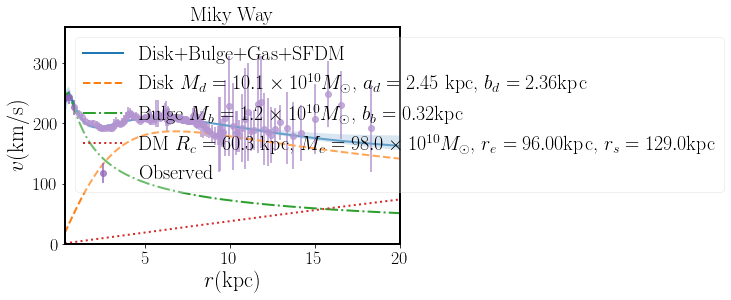

In [9]:
pm3.summary(trace).to_csv('%s/summary.csv' % dirfitsG)
plt.show()
y_min = np.percentile(trace.rot_vel,2.5,axis=0)
y_max = np.percentile(trace.rot_vel,97.5,axis=0)
y_fit = np.percentile(trace.rot_vel,50,axis=0)
rmin, rmax = np.amin(rad), 20.
name =   [r'$R_c$', r'$M_c$', r'$r_e$', r'$r_s$', r'$M_d$', r'$a_d$', r'$b_d$',
          r'$M_b$',r'$b_b$']

popt = pm3.summary(trace, var_names=name)['mean'].values ### summary keys ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'mcse_mean', 'mcse_sd', 'ess_mean', 'ess_sd', 'ess_bulk', 'ess_tail', 'r_hat']
Rc, Mc, re, rs, Md, ad, bd, Mb, bb = popt 
r = np.linspace(rmin, rmax, 1000)
pts.plotmultiple([rad, r, r, r], [y_fit, RC_miyamoto(r, G,  Md, ad, bd),
                 RC_miyamoto(r, G, Mb, 0., bb),
                  np.sqrt(v2_DM(r, Rc, Mc, re, rs))],
                 [r'Disk+Bulge+Gas+SFDM',
                  r'Disk $M_d = %.1f\times 10^{10} M_\odot$, $a_d = %.2f $ kpc, $b_d=%.2f$kpc'%(Md,ad,bd),
                  r'Bulge $M_b = %.1f\times 10^{10} M_\odot$, $b_b=%.2f$kpc'%(Mb,bb), 
                  r'DM  $R_c = %.1f$ kpc, $M_c = %.1f \times 10^{10} M_\odot$, $r_e=%.2f$kpc, $r_s=%.1f$kpc'%(Rc, Mc, re, rs),
                  'Observed'],
                 r'$r$(kpc)', r'$v$(km/s)', 'Miky Way',
                 '%sDM_fit_MCMC.png'%(dirfitsG), ylim = (0,360),
                 xlim = (rmin,rmax), data = True, xd = rad, yd = v, err = True,
                 yerr = v_error, fill_between = True,
                 fbx = rad, fby1 = y_min, fby2 = y_max)

In [10]:
fil= open("%s/cantidades_pymc3.txt"%dirfitsG,"w+")
cons = M_t(Rc, *popt)**2*Mc*1.0e9/1.45e4
mu2 = 1./np.sqrt(np.sqrt(cons))
mu = 1./(Rc*Gentc2*M_t(Rc, *popt))
fil.write('Nsamples = %d \r\n'%nsamples)
fil.write('Rc = %.2f kpc,  M(Rc) = %f x10^{10} M_sun \r\n'%(Rc, M_t(Rc, *popt)))
fil.write('r = 2.00 kpc,  M(20kpc) = %f x10^{10} M_sun \r\n'%(M_t(20., *popt)))
fil.write('mu = %f x10^{-22} eV/c^2,  mu = %f  x10^{-22} eV/c^2 \r\n'%(mu2, mu/15655.0))
fil.write('Mhalo(300kpc) = %f x10^{12} M_sun \r\n'%(M_CNFW(300., Rc, Mc, re, rs)*1e-2))
fil.close()

In [11]:
print('Rc =',Rc,'kpc', 'M(Rc) =',M_t(Rc, *popt), 'x10^{10} M_sun')
print('M(20kpc) =',M_t(20., *popt), 'x10^{10} M_sun')
print('mu =',mu2, 'x10^{-22} eV/c^2')
print('mu =',mu/15655.0, 'x10^{-22} eV/c^2')

Rc = 60.308 kpc M(Rc) = 52.74578480063257 x10^{10} M_sun
M(20kpc) = 12.3852270801096 x10^{10} M_sun
mu = 0.002700780269716284 x10^{-22} eV/c^2
mu = 0.0418440289031304 x10^{-22} eV/c^2


In [12]:
import matplotlib as mpl
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1
az.rcParams['plot.max_subplots']= 80

/home/jordi/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



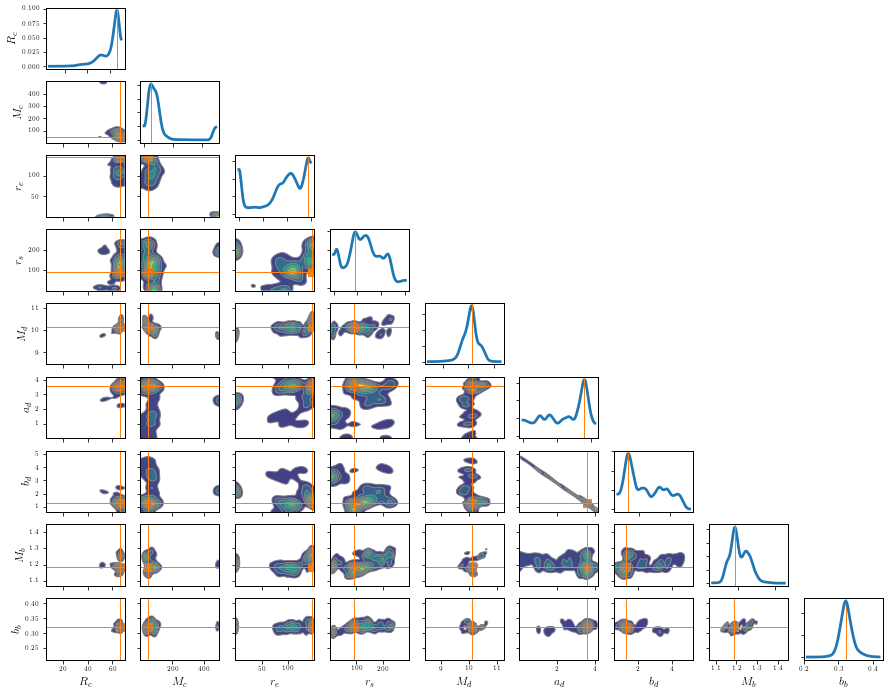

In [13]:
ax = az.plot_pair(trace, var_names = name, kind = 'kde',# kind = ["scatter", "kde"],
                  kde_kwargs={"fill_last": False}, marginals=True,
                  point_estimate="mode", figsize=(15, 12))
plt.savefig('%sDM_fit_MCMC_pars.png'%(dirfitsG), bbox_inches='tight')
plt.show()

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
mpl.rcParams.update(mpl.rcParamsDefault)
#pm3.traceplot(trace, varnames=name)
pm3.plot_posterior(trace, name[1],figsize=(5, 4))
for i in(0, 1,2,3,6):
    az.plot_density(trace, var_names=name[i], shade=0.1, point_estimate='mean' )
    plt.savefig('%sDM_fit_MCMC_%s.png'%(dirfitsG, name[i]), bbox_inches='tight')